<a href="https://colab.research.google.com/github/sudhee30/Basics_of_ML/blob/main/Copy_of_GenAIIntern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/flight_ticket_price_prediction_dataset.csv')

In [ ]:
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nSummary statistics:")
print(df.describe())


print("\nMissing values per column:")
print(df.isnull().sum())


df_cleaned = df.dropna()


for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].mean(), inplace=True)

print("\nMissing values after handling:")
print(df.isnull().sum())


df_encoded = pd.get_dummies(df, drop_first=True)

print("\nData after One-Hot Encoding:")
print(df_encoded.head())


df_encoded.to_csv('cleaned_encoded_dataset.csv', index=False)

   FlightID    Airline DepartureAirport ArrivalAirport        DepartureDate  \
0         1      Delta              ORD            ORD  2024-01-01 00:00:00   
1         2  Southwest              ATL            ATL  2024-01-01 01:00:00   
2         3   American              JFK            ATL  2024-01-01 02:00:00   
3         4     United              ATL            DFW  2024-01-01 03:00:00   
4         5    JetBlue              ORD            ATL  2024-01-01 04:00:00   

   Distance  FlightDuration    Class  NumberOfStops  DaysUntilDeparture  \
0      3194            4.46    First              0                  89   
1       544            4.95    First              0                 211   
2      1847            3.73    First              1                 301   
3      2727            6.25  Economy              1                 164   
4      2721            1.23    First              2                 217   

  DayOfWeek  TicketPrice  
0    Monday      1478.37  
1    Monday      170

In [ ]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


numerical_columns = df_encoded.select_dtypes(include=['float64', 'int64']).columns


scaler_standard = StandardScaler()
df_scaled_standard = df_encoded.copy()
df_scaled_standard[numerical_columns] = scaler_standard.fit_transform(df_encoded[numerical_columns])

print("\nData after Standardization:")
print(df_scaled_standard.head())


scaler_normal = MinMaxScaler()
df_scaled_normal = df_encoded.copy()
df_scaled_normal[numerical_columns] = scaler_normal.fit_transform(df_encoded[numerical_columns])

print("\nData after Normalization:")
print(df_scaled_normal.head())


if 'price' in df_encoded.columns and 'distance' in df_encoded.columns:
    df_encoded['price_per_mile'] = df_encoded['price'] / df_encoded['distance']


if 'duration' in df_encoded.columns and 'distance' in df_encoded.columns:
    df_encoded['duration_per_mile'] = df_encoded['duration'] / df_encoded['distance']

print("\nData after Feature Engineering:")
print(df_encoded.head())


pca = PCA(n_components=0.95)
df_pca = pca.fit_transform(df_scaled_standard[numerical_columns])

print("\nExplained variance ratio of each PCA component:")
print(pca.explained_variance_ratio_)

print("\nData after PCA:")
print(df_pca[:5])



Data after Standardization:
   FlightID  Distance  FlightDuration  NumberOfStops  DaysUntilDeparture  \
0 -1.731704  0.404307       -0.650687      -1.207778           -0.876607   
1 -1.731012 -1.507755       -0.496173      -1.207778            0.287401   
2 -1.730319 -0.567598       -0.880881       0.005094            1.146096   
3 -1.729626  0.067351       -0.086239       0.005094           -0.161028   
4 -1.728933  0.063022       -1.669216       1.217966            0.344648   

   TicketPrice  Airline_Delta  Airline_JetBlue  Airline_Southwest  \
0     0.815505           True            False              False   
1     1.215972          False            False               True   
2    -0.485297          False            False              False   
3     1.148851          False            False              False   
4     0.079292          False             True              False   

   Airline_United  ...  DepartureDate_2024-07-27 06:00:00  \
0           False  ...                

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
X = df_encoded.drop(columns=['TicketPrice'])
y = df_encoded['TicketPrice']

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize regression models
linear_model = LinearRegression()
decision_tree = DecisionTreeRegressor(random_state=42)
random_forest = RandomForestRegressor(random_state=42)
gradient_boosting = GradientBoostingRegressor(random_state=42)

# Train models
models = {
    'Linear Regression': linear_model,
    'Decision Tree': decision_tree,
    'Random Forest': random_forest,
    'Gradient Boosting': gradient_boosting
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'{model_name} Mean Squared Error: {mse:.4f}')

Linear Regression Mean Squared Error: 329695.8852
Decision Tree Mean Squared Error: 636303.3959
Random Forest Mean Squared Error: 323798.2241
Gradient Boosting Mean Squared Error: 320570.1474


In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Initialize RandomForest and GradientBoosting models
random_forest = RandomForestRegressor(random_state=42)
gradient_boosting = GradientBoostingRegressor(random_state=42)

# Reduced parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 150],  # Fewer options to explore
    'max_depth': [10, 20],  # Simpler max depth choices
}

# Perform Grid Search for Random Forest with reduced grid
grid_search_rf = GridSearchCV(estimator=random_forest, param_grid=param_grid_rf,
                              cv=3, n_jobs=-1, scoring='neg_mean_squared_error')  # Fewer CV folds (3)
grid_search_rf.fit(X_train, y_train)

print(f'Best parameters for Random Forest: {grid_search_rf.best_params_}')
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Optimized Random Forest MSE: {mse_rf:.4f}')

# Reduced parameter distribution for Gradient Boosting
param_dist_gb = {
    'n_estimators': [100, 150],  # Fewer options for faster execution
    'learning_rate': [0.05, 0.1],  # Simple learning rates
    'max_depth': [3, 5],  # Limiting depth options
}

# Perform Randomized Search for Gradient Boosting with reduced params
random_search_gb = RandomizedSearchCV(estimator=gradient_boosting, param_distributions=param_dist_gb,
                                      n_iter=5, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)  # Only 5 iterations
random_search_gb.fit(X_train, y_train)

print(f'Best parameters for Gradient Boosting: {random_search_gb.best_params_}')
best_gb_model = random_search_gb.best_estimator_
y_pred_gb = best_gb_model.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
print(f'Optimized Gradient Boosting MSE: {mse_gb:.4f}')


Best parameters for Random Forest: {'max_depth': 10, 'n_estimators': 150}
Optimized Random Forest MSE: 319442.6051
Best parameters for Gradient Boosting: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}
Optimized Gradient Boosting MSE: 320121.4710


Model: LinearRegression
Mean Absolute Error (MAE): 489.9741
Mean Squared Error (MSE): 329695.8852
Root Mean Squared Error (RMSE): 574.1915
R-squared (R2): -0.0306
----------------------------------------
Model: DecisionTreeRegressor
Mean Absolute Error (MAE): 654.6813
Mean Squared Error (MSE): 636303.3959
Root Mean Squared Error (RMSE): 797.6863
R-squared (R2): -0.9891
----------------------------------------
Model: RandomForestRegressor
Mean Absolute Error (MAE): 487.7972
Mean Squared Error (MSE): 323798.2241
Root Mean Squared Error (RMSE): 569.0327
R-squared (R2): -0.0122
----------------------------------------
Model: GradientBoostingRegressor
Mean Absolute Error (MAE): 484.8465
Mean Squared Error (MSE): 320570.1474
Root Mean Squared Error (RMSE): 566.1891
R-squared (R2): -0.0021
----------------------------------------
Model: RandomForestRegressor
Mean Absolute Error (MAE): 484.5682
Mean Squared Error (MSE): 319442.6051
Root Mean Squared Error (RMSE): 565.1925
R-squared (R2): 0.001

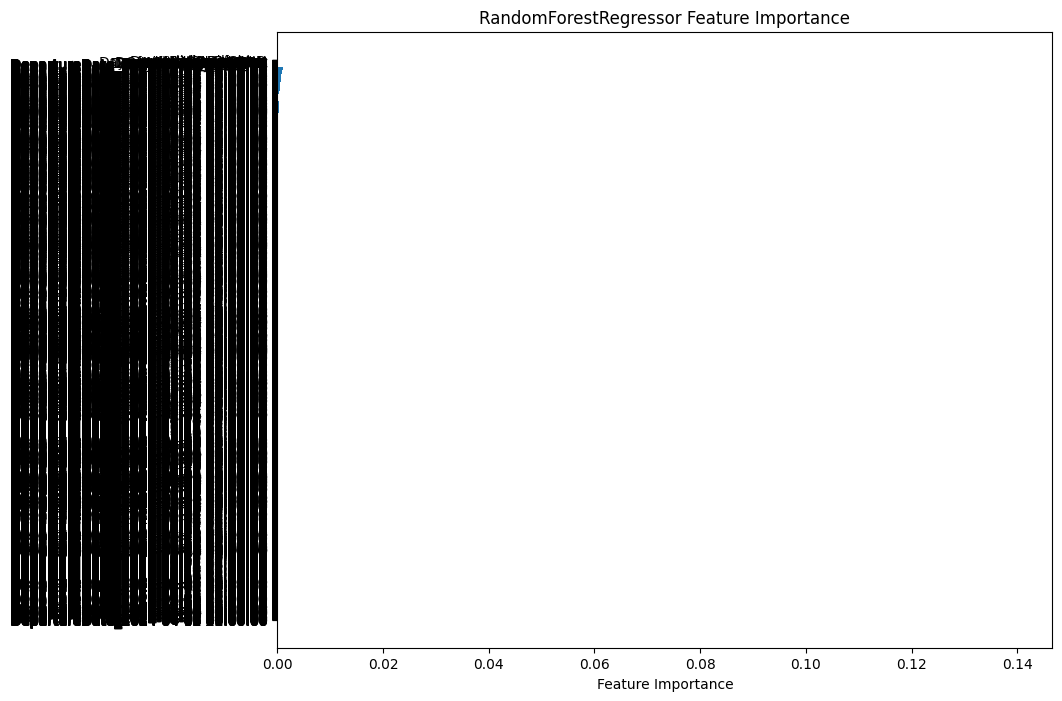

In [ ]:
# Import necessary libraries for evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"Model: {model.__class__.__name__}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R2): {r2:.4f}")
    print("-" * 40)
    return {'Model': model.__class__.__name__, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

# Evaluate each model
evaluation_results = []
for model_name, model in models.items():
    result = evaluate_model(model, X_test, y_test)
    evaluation_results.append(result)

# Evaluate the optimized Random Forest and Gradient Boosting models
evaluation_results.append(evaluate_model(best_rf_model, X_test, y_test))
evaluation_results.append(evaluate_model(best_gb_model, X_test, y_test))

# Convert evaluation results into a DataFrame for easier comparison
import pandas as pd
eval_df = pd.DataFrame(evaluation_results)
print("\nModel Comparison:")
print(eval_df)

# Analyzing feature importance for the best performing model (e.g., Random Forest or Gradient Boosting)
# Assuming Random Forest is the best, analyze feature importance
import matplotlib.pyplot as plt

def plot_feature_importance(model, X_train):
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)
    plt.figure(figsize=(10, 8))
    plt.barh(X_train.columns[sorted_idx], feature_importances[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title(f'{model.__class__.__name__} Feature Importance')
    plt.show()

# Plot feature importance for the best model (you can replace 'best_rf_model' with the best model found)
plot_feature_importance(best_rf_model, X_train)
